In [391]:
from pymongo import MongoClient
import pprint
import json
from bs4 import BeautifulSoup
import re

from Scraper import gr_db_cleaner


In [3]:

client = MongoClient('localhost', 27017)
db=client['reviews']
coll=db['user_reviews']

.find() creates a "cursor" which pulls the data. .limit() keeps you from pulling all the data. Wrapping the "cursor" in a list comprehension builds that cursor out iteratively into a list containing the things you want to manipulate. Ok? Cool. 

In [178]:
test = [x for x in coll.find().limit(1000)]
test[0]['userid']

7171593

now, its more complicated than that, because all of this is nested *again* So in the cursor list? you've got a dictonary that holds user_id and a list of reviews. so index into 'reviews' and you get to a list of your actual scraped bits, the data from goodreads. 

In [189]:
review = test[3]['reviews']

you're going to want to make those giant strings of html into a handle-able-able object. So put it in a bowl with beatiful soup. 

In [52]:
soup = BeautifulSoup(review, 'html.parser')

In [409]:
print(soup.prettify())

<tr class="bookalike review" id="review_667385890">
 <td class="field checkbox">
  <label>
   checkbox
  </label>
  <div class="value">
  </div>
 </td>
 <td class="field position" style="display: none">
  <label>
   position
  </label>
  <div class="value">
  </div>
 </td>
 <td class="field cover">
  <label>
   cover
  </label>
  <div class="value">
   <div class="js-tooltipTrigger tooltipTrigger" data-resource-id="2767052" data-resource-type="Book">
    <a href="/book/show/2767052-the-hunger-games">
     <img alt="The Hunger Games (The Hunger Games, #1)" id="cover_review_667385890" src="https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1447303603l/2767052._SX50_.jpg"/>
    </a>
   </div>
  </div>
 </td>
 <td class="field title">
  <label>
   title
  </label>
  <div class="value">
   <a href="/book/show/2767052-the-hunger-games" title="The Hunger Games (The Hunger Games, #1)">
    The Hunger Games
    <span class="darkGreyText">
     (The Hunger Games, #1)
    </spa

In [435]:
author = soup.find_all(class_ = re.compile('author'))[0].text.strip('author ').split('\n')[0]
author

'Collins, Suzanne'

In [422]:
book_type =soup.find_all(class_ = re.compile('format'))[0].text.split('\n')[1].strip()
book_type


'Hardcover'

In [421]:
isbn = int(soup.find_all(class_ = re.compile('isbn13'))[0].text.strip('isbn13').strip())
isbn

9780439023481

In [242]:
title = soup.find_all(class_ = re.compile('title'))[0].text.split('\n')[1].strip()
title


'The Hunger Games'

In [196]:
title = soup.find_all(class_ = re.compile('title'))[0].text
title

'title \n      The Hunger Games\n        (The Hunger Games, #1)\n'

In [252]:
pages = int(soup.find_all(class_ =re.compile('num_pages'))[0].text.split()[2])
pages

374

In [211]:
av_rate = float(soup.find_all(class_ =re.compile('avg_rating'))[0].text.split()[2])
av_rate

4.33

In [214]:
num_rate = int(soup.find_all(class_ =re.compile('num_ratings'))[0].text.split()[2].replace(',',''))
num_rate

5936319

In [232]:
def str_to_rate(qual_state):
    '''
    a function that turns goodreads's "I liked it" or "I did not like it" star categories
    into the numerical 1-5 rating that they visually imply. 
    ++++++
    Attributes
    qual_state (list) a split string pulled from the beautiful soup output of .text on the rating object
    ++++++
    Returns
    user_rating (int): 1-5 score based on NUMBER OF STARS SELECTED BY THE RATER. I honestly don't understand why that's not the output in the HTML. 
    '''
    if qual_state[-3:] == ['it', 'was', 'amazing']:
        user_rating = 5
    elif qual_state[-3:] ==['really','liked','it']:
        user_rating = 4
    elif qual_state[-2:] ==['liked', 'it']:
        '''note that I belive any that include "really" will be given 4
        before we get to this elif statement, therefore we don't need 
        to worry about the issues of "really liked it" and "liked it"
        overlapping'''
        user_rating= 3
    elif qual_state[-3:]==['it','was','ok']:
        user_rating = 2
    elif qual_state[-3:]==['not','like','it']:
        user_rating = 1
    else:
        user_rating = 0
    return user_rating



In [233]:
user_rating = str_to_rate(soup.find_all(class_ =re.compile('field rating'))[0].text.split())
user_rating

5

**Putting it all together**

In [445]:
def cleaner(find_lim = 10):
    '''
    a function that reads in goodreads user review tables gathered
    by the gr_scraper and returns a list for schema
    +++++++++++
    Atributes
    find_lim (int): how many user-reviews to clean.  
    +++++++
    '''
    
    client = MongoClient('localhost', 27017)
    db=client['reviews']
    collection=db['user_reviews']

    documents = [x for x in collection.find().limit(find_lim)]
    all_revs = []
    for idx, users in enumerate(documents):
        userid = documents[idx]['userid']
        review_list = documents[idx]['reviews']
        if len(review_list) ==0:
            sub_rev = [None, None, None, None, None, userid, None, None, None]
            all_revs.append(sub_rev)
        else:
            for review in review_list:
                soup = BeautifulSoup(review, 'html.parser')
                title = soup.find_all(class_ = re.compile('title'))[0].text.split('\n')[1].strip()
                try:
                    pages = int(soup.find_all(class_ =re.compile('num_pages'))[0].text.split()[2])
                except:
                    pages = None
                try:
                    isbn = int(soup.find_all(class_ = re.compile('isbn13'))[0].text.strip('isbn13').strip())
                except:
                    isbn = None
                book_type = soup.find_all(class_ = re.compile('format'))[0].text.split('\n')[0].strip()
                author = soup.find_all(class_ = re.compile('author'))[0].text.strip('author ').split('\n')[0]

                av_rate = float(soup.find_all(class_ =re.compile('avg_rating'))[0].text.split()[2])
                num_rate = int(soup.find_all(class_ =re.compile('num_ratings'))[0].text.split()[2].replace(',',''))
                user_rating = str_to_rate(soup.find_all(class_ =re.compile('field rating'))[0].text.split())
                sub_rev = [title,author, isbn, book_type, pages, userid, user_rating, num_rate, av_rate]
                all_revs.append(sub_rev)
    client.close()
    return all_revs

In [446]:
data = cleaner(1000)

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline



In [447]:
df = pd.DataFrame(data, columns = ['title','author', 'isbn', 'book_type', 'pages', 'userid', 'user_rating', 'num_rate', 'av_rate'])  

#get rid of any users who haven't added any books, and any added books with no user rating
dfwr = df.dropna(axis=0)
actually_rated = dfwr['user_rating'] != 0
dfwr = dfwr[actually_rated]

In [448]:
dfwr.sort_values('title').head(20)



,title,author,isbn,book_type,pages,userid,user_rating,num_rate,av_rate
1370,"""B"" Is for Betsy","Haywood, Carolyn",9.780152e+12,format,144.0,58878680,5.0,4494.0,4.03
2268,"""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية","الجندي, حسن",9.789775e+12,format,127.0,17981752,5.0,9565.0,3.55
2855,'Salem's Lot,"King, Stephen",9.780450e+12,format,483.0,5918419,5.0,305390.0,4.02
1364,"1,000 Places to See Before You Die","Schultz, Patricia",9.780761e+12,format,992.0,58878680,5.0,37105.0,3.85
2527,11/22/63,"King, Stephen",9.781452e+12,format,849.0,44623,5.0,386481.0,4.31
100,11/22/63,"King, Stephen",9.781452e+12,format,849.0,14045650,5.0,386395.0,4.31
1956,11/22/63,"King, Stephen",9.781452e+12,format,849.0,56772139,5.0,386411.0,4.31
1805,12 Rules for Life: An Antidote to Chaos,"Peterson, Jordan B.",9.780346e+12,format,409.0,71610658,4.0,69167.0,3.96
2291,13 Días,"Giambanco, Valentina",9.788415e+12,format,464.0,30846404,5.0,876.0,3.63
2768,1491: New Revelations of the Americas Before C...,"Mann, Charles C.",9.781400e+12,format,541.0,12791873,5.0,58440.0,4.03


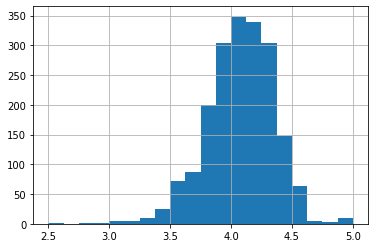

In [384]:
dfwr['av_rate'].hist(bins = 20)

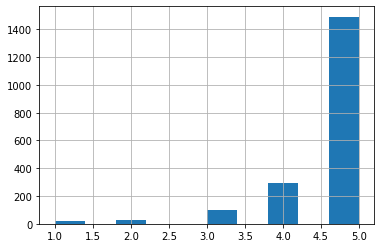

In [382]:
dfwr['user_rating'].hist()

Its pretty clear, from these histograms, that at least in the initial thousand user-reviews sampled in my dataset, that goodreads reviews are heavily weighted towards the high end of the scale. lets do a simple hypothesis test and see where we stand against statistics

In [458]:
#sample is all of our user ratings, sampling was done as part of the scraping randomized list operation
sample =dfwr['user_rating']

np.std(sample)

0.7282563831386586

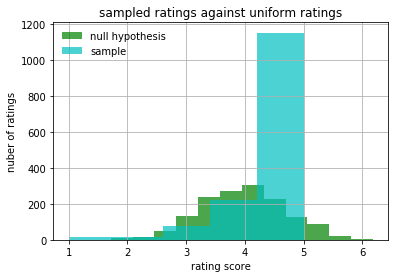

In [462]:
# graph the sample and the hypothesis(a uniform distribution of the same size as the sample)
null_hyp = stats.norm.rvs(loc=4, scale=np.std(sample), size=len(sample), random_state=None)
fig, ax = plt.subplots()

ax = plt.hist(null_hyp, color = 'g', bins = 12, alpha = .7, label = 'null hypothesis')
ax = sample.hist(color = 'c', bins = 5, alpha = .7, label ='sample')

ax.set_title('sampled ratings against uniform ratings')
ax.set_ylabel('nuber of ratings')
ax.set_xlabel('rating score')

ax.legend(loc='upper left', frameon = False)
#fig.xlabel('number of ratings')
plt.show()

fig.savefig('img/hypothesis_graph', dpi = 300, bbox_inches = 'tight', transparent = True)

In [463]:
stats.ttest_1samp(sample, 4, axis=0, nan_policy='propagate')

Ttest_1sampResult(statistic=35.28854661575597, pvalue=1.2852902062632924e-198)

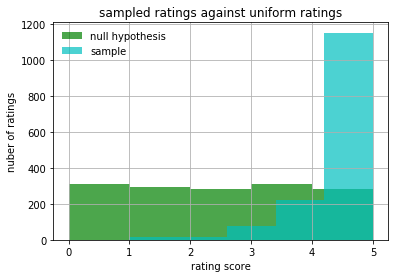

In [468]:
# graph the sample and the hypothesis(a uniform distribution of the same size as the sample)
null_hyp = stats.uniform.rvs(loc=0, scale=5, size=len(sample), random_state=None)
fig, ax = plt.subplots()

ax = plt.hist(null_hyp, color = 'g', bins = 5, alpha = .7, label = 'null hypothesis')
ax = sample.hist(color = 'c', bins = 5, alpha = .7, label ='sample')

ax.set_title('sampled ratings against uniform ratings')
ax.set_ylabel('nuber of ratings')
ax.set_xlabel('rating score')

ax.legend(loc='upper left', frameon = False)
#fig.xlabel('number of ratings')
plt.show()

fig.savefig('img/uniform_rational_graph', dpi = 300, bbox_inches = 'tight', transparent = True)